<a href="https://colab.research.google.com/github/andreidhoang/deep_learning_from_first_principles/blob/main/1_Deeplearning_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Undestand Deep Learning From First Principles and Build a Deep Neural Network from Scratch

- In deep learning, our goal will be to fit a model to some data. More precisely, this means that we want to find **a mathematical function** that maps observations from the data — which will be inputs to the function. — to some desired predictions from the data — which will be the outputs of the function—in as optimal a way as possible.
- It turns out these observations will be encoded in matrices, typically with row as an observation and each column as a numeric feature for that observation

## The derivative with respect to a matrix

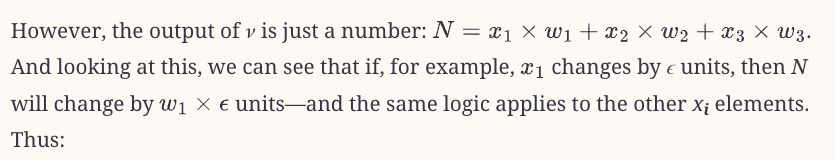

- “the derivative with respect to a matrix” really means “the derivative with respect to each element of the matrix.”


```
dv/dX = [dv/dx1 dv/dx2 dv/dx3]
```

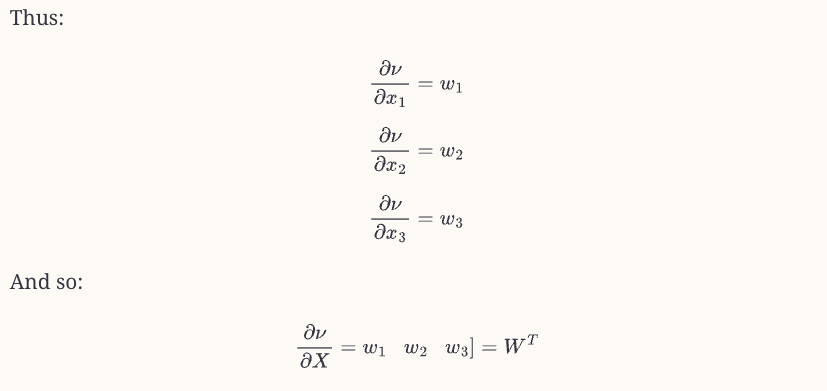

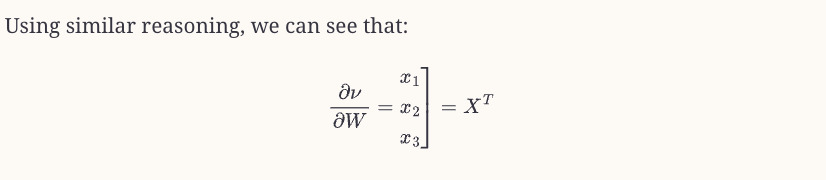


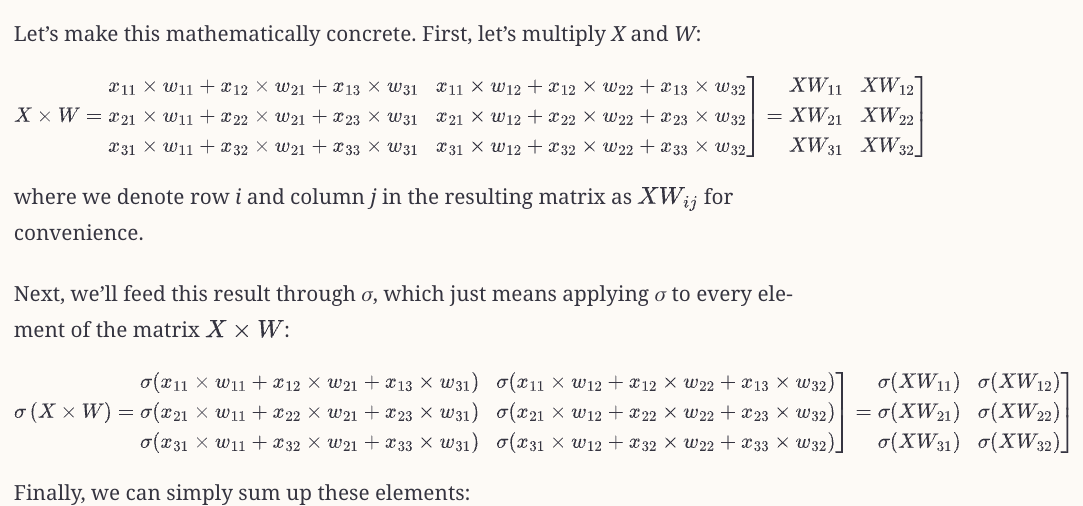

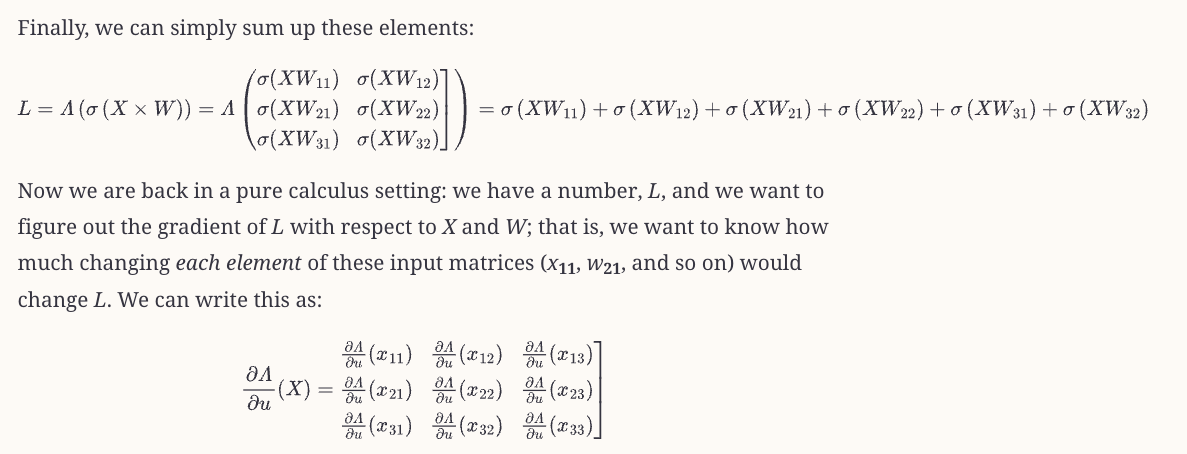

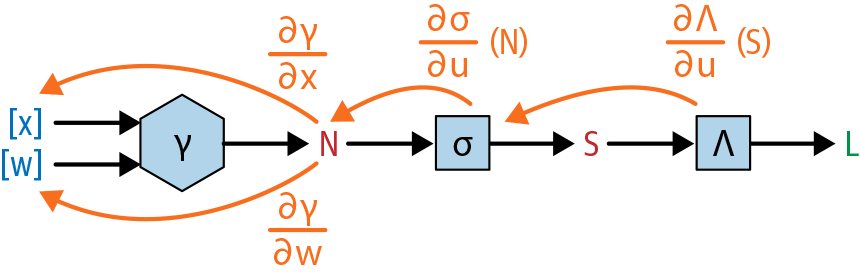

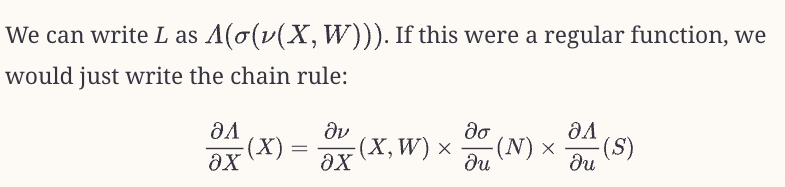

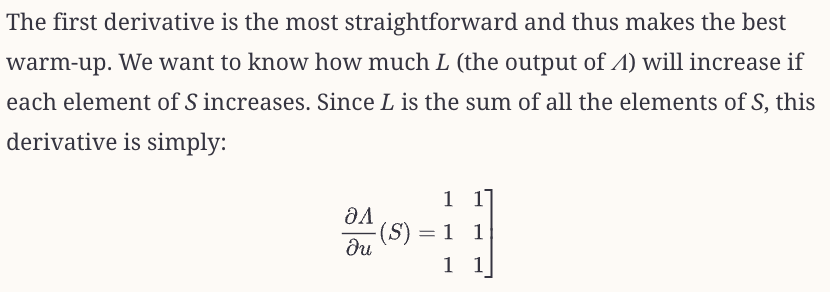

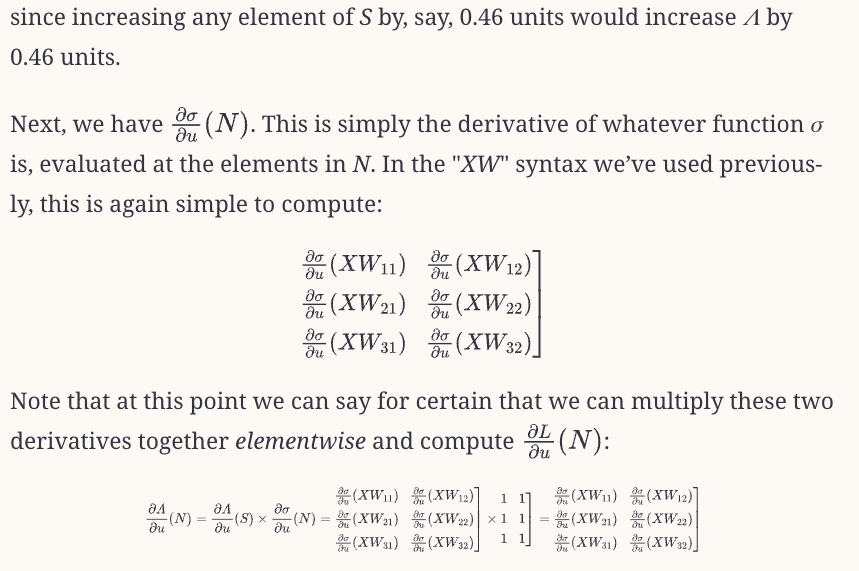

N, the output of ν, was just the result of a matrix multiplication of X with W. Thus we want some notion of how much increasing each element of X (a 3 × 3 matrix) will increase each element of N (a 3 × 2 matrix).

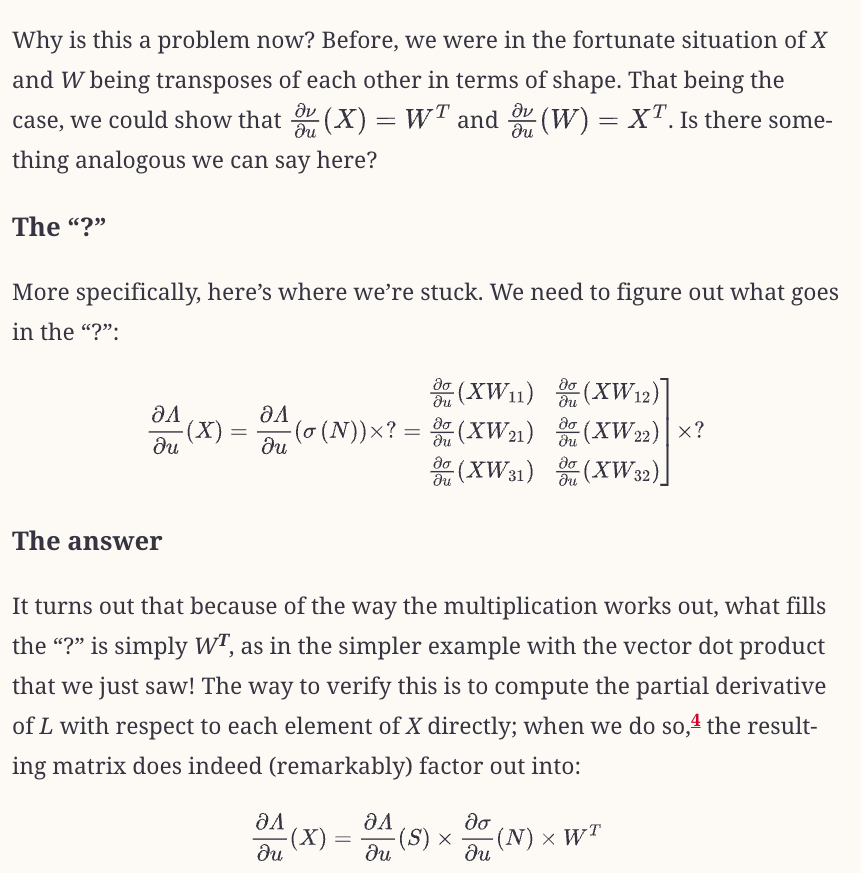

## Build a Deep Neural Network from Scratch

1. Repeatedly feed observations through the model, keeping track of the quantities computed along the way during this “forward pass.”

2. Calculate a loss representing how far off our model’s predictions were from the desired outputs or target.

3. Using the quantities computed on the forward pass and the chain rule math worked out in Chapter 1, compute how much each of the input parameters ultimately affects this loss.

4. Update the values of the parameters so that the loss will hopefully be reduced when the next set of observations is passed through the model.

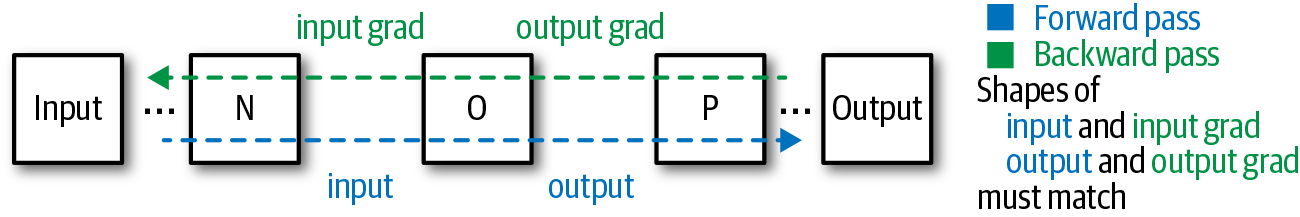

Figure 3-1. An Operation, with input and output


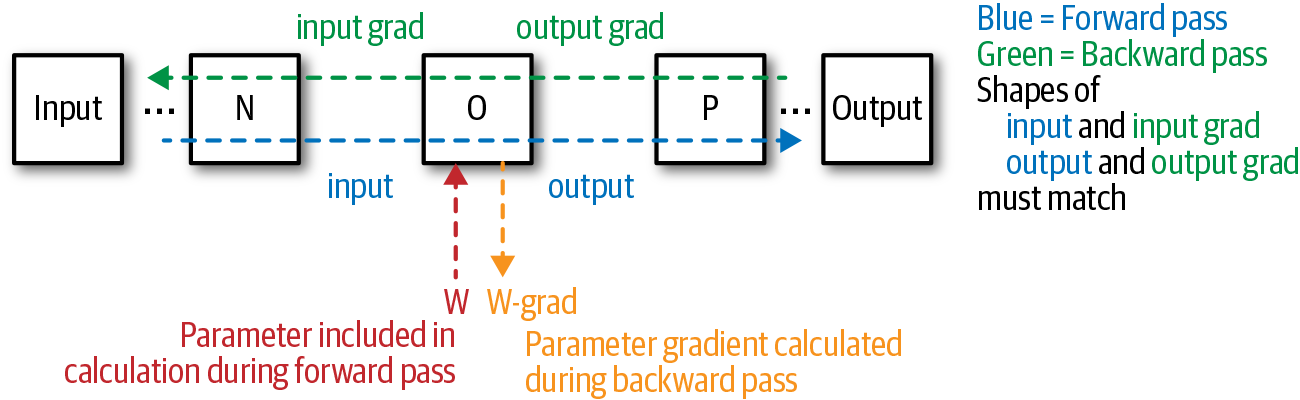
Figure 3-2. A ParamOperation, with input and output and parameters


### 1. Core Building Blocks: `Operation` and `ParamOperation`

In [17]:
import numpy as np
from numpy import ndarray

from typing import List

def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
  assert array.shape == array_grad.shape, \
        '''
        Two ndarrays should have the same shape;
        instead, first ndarray's shape is {0}
        and second ndarray's shape is {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
  return None

In [14]:
class Operation(object):
  '''
  Base class for an "operation" in a neural network.
  '''
  def __init__(self):
    pass

  def forward(self, input_: ndarray):
    '''
    Stores input in the self._input instance variable
    Calls the self._output() function.
    '''
    self.input_ = input_

    self.output = self._output()

    return self.output

  def backward(self, output_grad: ndarray) -> ndarray:
    '''
    Calls the self._input_grad() function.
    Checks that the appropriate shapes match.
    '''
    assert_same_shape(self.output, output_grad)

    self.input_grad = self._input_grad(output_grad)

    assert_same_shape(self.input_, self.input_grad)

    return self.input_grad

  def _output(self) -> ndarray:
    '''
    The _output method must be defined for each Operation.
    '''
    raise NotImplementedError()

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    '''
    The _input_grad method must be defined for each Operation.
    '''
    raise NotImplementedError()

## For any individual Operation that we define, we’ll have to implement the
## _output and _input_grad functions,
## so named because of the quantities they compute.

This Operation class represents a generic computation in a neural network. Each operation:

1. Takes an input
2. Produces an output (forward pass)
3. Computes gradients (backward pass)

The ParamOperation extends this concept by adding parameters (weights, biases) that need to be learned:

**Note**

- We’re defining base classes like this primarily for pedagogical reasons: it is important to have the mental model that all Operations you’ll encounter throughout deep learning fit this blueprint of sending inputs forward and gradients backward, with the shapes of what they receive on the forward pass matching the shapes of what they send backward on the backward pass, and vice versa.

In [2]:
class ParamOperation(Operation):
  '''
  An Operation with parameters.
  '''

  def __init__(self, param: ndarray) -> ndarray:
    '''
    The ParamOperation method
    '''
    super().__init__()
    self.param = param

  def backward(self, output_grad: ndarray) -> ndarray:
    '''
    Calls self._input_grad and self._param_grad.
    Checks appropriate shapes.
    '''

    assert_same_shape(self.output, output_grad)

    self.input_grad = self.input_grad(output_grad)
    self.param_grad = self._param_grad(output_grad)

    assert_same_shape(self.input_, self.input_grad)
    assert_same_shape(self.param, self.param_grad)

    return self.input_grad

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    '''
    Every subclass of ParamOperation must implement _param_grad.
    '''
    raise NotImplementedError()

### The Building Blocks of Neural Networks: Layers

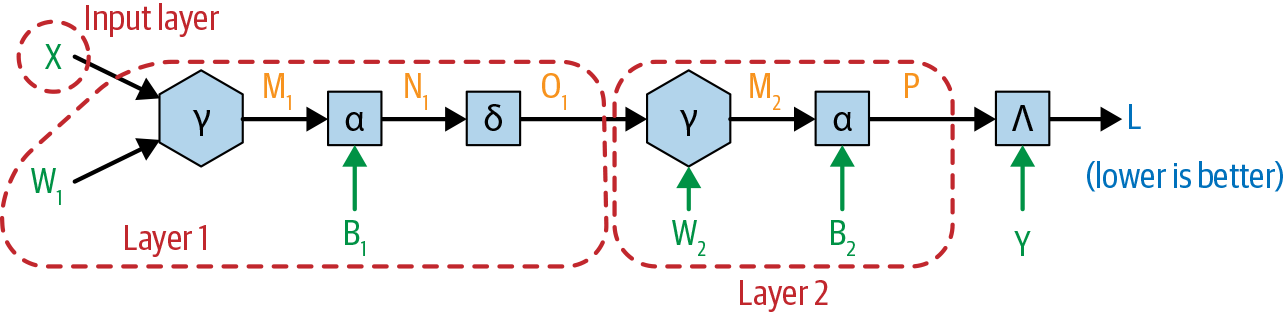

Figure 3-3. The neural network from the prior chapter with the operations grouped into layers

- Each layer can be said to have a certain number of neurons equal to the dimensionality of the vector that represents each observation in the layer’s output.

- The matrix multiplication of the input with the matrix of parameters

- The addition of a bias term

- The sigmoid activation function

In [3]:
class WeightMultiply(ParamOperation):
  '''
  Weight multiplication operation for a neural network.
  '''

  def __init__(self, W: ndarray):
    '''
    Initialize Operation with self.param = W.
    '''
    super.__init__(W)

  def _output(self) -> ndarray:
    '''
    compute output
    '''
    return np.dot(self.input_, self.param)

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    '''
    compute input gradient
    '''
    return np.dot(output_grad, np.transpose(self.param, (1, 0)))

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    '''
    compute parameter gradient
    '''
    return np.dot(np.transpose(self.input_, (1, 0)), output_grad)


Here we simply code up the matrix multiplication on the forward pass, as well as the rules for “sending gradients backward” to both the inputs and the parameters on the backward pass

In [4]:
class BiasAdd(ParamOperation):
  '''
  Compute bias addition.
  '''
  def __init__(self, B: ndarray):
    '''
    Initialize with self.param = B.
    '''
    assert B.shape[0] == 1
    super().__init__(B)

  def _output(self) -> ndarray:
    '''
    Compute output
    '''
    return self.input_ + self.param

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    '''
    Compute input gradient.
    '''
    return np.ones_like(self.input_) * output_grad

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    '''
    Compute parameter gradient.
    '''
    param_grad = np.ones_like(self.param) * output_grad
    return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [7]:
class Sigmoid(Operation):
  '''
  Sigmoid activation function.
  '''

  def __init__(self) -> None:
    '''Pass'''
    super().__init__()

  def _output(self) -> ndarray:
    '''
    Compute output.
    '''
    return 1.0/(1.0+np.exp(-1.0 * self.input_))

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    '''
    Compute input gradient.
    '''
    sigmoid_backward = self.output * (1.0 - self.output)
    input_grad = sigmoid_backward * output_grad
    return input_grad

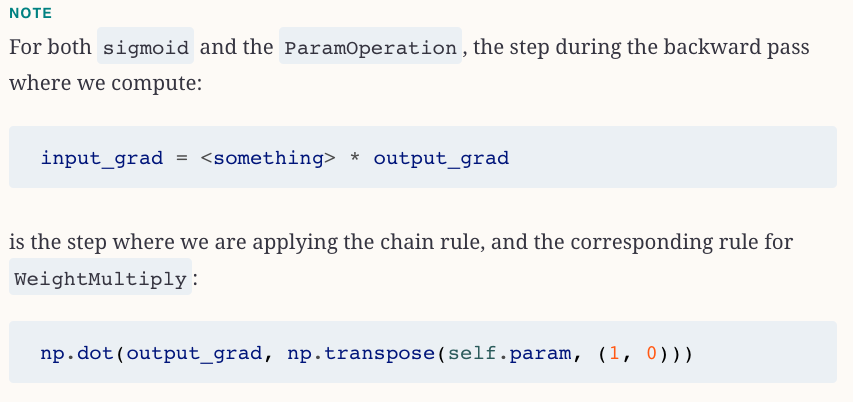

### The Layer Blueprint

- The `forward` and `backward` methods simply involve sending the input successively forward through a series of `Operations`—exactly as we’ve been doing in the diagrams all along! This is the most important fact about the working of `Layers`; the rest of the code is a wrapper around this and mostly involves bookkeeping:
  - Defining the correct series of `Operations` in the `_setup_layer` function and initializing and storing the parameters in these `Operations` (which will also take place in the _setup_layer function)
  - Storing the correct values in `self.input_ `and `self.output` on the `forward` method
  - Performing the correct assertion checking in the `backward` method
- Finally, the `_params` and `_param_grads` functions simply extract the parameters and their gradients (with respect to the loss) from the `ParamOperations` within the layer.

In [8]:
from typing import List
class Layer:
  '''
  A layer of neurons in a neural network
  '''

  def __init__(self, neurons: int):
    '''
    The number of "neurons" roughly corresponds to the "breadth" of the layer
    '''
    self.neurons = neurons
    self.first = True
    self.params: List[ndarray] = []
    self.param_grads: List[ndarray] = []
    self.operations: List[Operation] = []

  def _setup_layer(self, num_in: int) -> None:
    '''
    The _setup_layer function must be implemented for each layer.
    '''
    raise NotImplementedError()

  def forward(self, input_: ndarray) -> ndarray:
    '''
    Passes input forward through a series of operations.
    '''
    if self.first:
      self._setup_layer(input_)
      self.first = False

    self.input_ = input_

    for operation in self.operations:
      input_ = operation.forward(input_)

    self.output = input_

    return self.output

  def backward(self, output_grad: ndarray) -> ndarray:
    '''
    Passes output_grad backward through a series of operations.
    Checks appropriate shapes.
    '''
    assert_same_shape(self.output, output_grad)

    for operation in reversed(self.operations):
      output_grad = operation.backward(output_grad)

    input_grad = output_grad

    self._param_grads()

    return input_grad

  def _param_grad(self) -> ndarray:
    '''
    Extracts the _param_grads from a layer's operations.
    '''

    self.param_grads = []
    for operation in self.operations:
      if issubclass(operation.__class__, ParamOperation):
        self.param_grads.append(operation.param_grad)

  def _params(self) -> ndarray:
    '''
    Extracts the _params from a layer's operations.
    '''

    self.params = []
    for operation in self.operations:
      if issubclass(operation.__class__, ParamOperation):
        self.params.append(operation.param)

In [9]:
class Dense(Layer):
  '''
  A fully connected layer that inherits from "Layer."
  '''
  def __init__(self,
               neurons: int,
               activation: Operation = Sigmoid()) -> None:
    '''
    Requires an activation function upon initialization.
    '''
    super().__init__(neurons)
    self.activation = activation

  def _setup_layer(self, input_: ndarray) -> None:
    '''
    Defines the operations of a fully connected layer.
    '''
    if self.seed:
      np.random.seed(self.seed)

    self.params = []

    # weights
    self.params.append(np.random.randn(input_.shape[1], self.neurons))

    # biases
    self.params.append(np.random.randn(1, self.neurons))

    self.operations = [WeightMultiply(self.params[0]),
                       BiasAdd(self.params[1]),
                       self.activation]

    return None


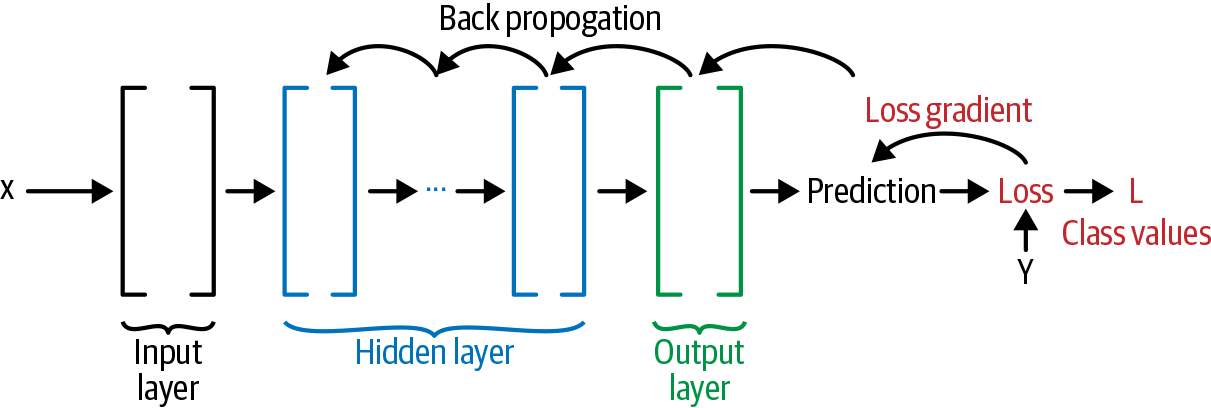

In [10]:
class Loss(object):
  '''
  The "loss" of a neural network.
  '''

  def __init__(self):
    '''Pass'''
    pass

  def forward(self, prediction: ndarray, target: ndarray) -> float:
    '''
    Computes the actual loss value.
    '''
    assert_same_shape(prediction, target)

    self.prediction = prediction
    self.target = target

    loss_value = self._output()

    return loss_value

  def backward(self) -> ndarray:
    '''
    Computes gradient of the loss value with respect to the input to the
    loss function.
    '''
    self.input_grad = self._input_grad()

    assert_same_shape(self.prediction, self.input_grad)

    return self.input_grad

  def _output(self) -> float:
    '''
    Every subclass of "Loss" must implement the _output function.
    '''
    raise NotImplementedError()

  def _input_grad(self) -> ndarray:
    '''
    Every subclass of "Loss" must implement the _input_grad function.
    '''
    raise NotImplementedError()

In [12]:
class MeanSquaredError(Loss):

  def __init__(self):
    '''Pass'''
    super().__init__()

  def _output(self) -> float:
    '''
    Computes the per-observation squared error loss.
    '''
    loss = np.sum(np.power(self.prediction - self.target, 2)) / self.prediction.shape[0]

    return loss

  def _input_grad(self) -> ndarray:
    '''
    Computes the loss gradient with respect to the input for MSE loss.
    '''

    return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]



1. A `NeuralNetwork` will have a list of `Layers` as an attribute. The `Layers` would be as defined previously, with `forward` and `backward` methods. These methods take in `ndarray` objects and return `ndarray` objects.

2. Each Layer will have a list of `Operations` saved in the `operations` attribute of the layer during the `_setup_layer` function.

3. These `Operations`, just like the Layer itself, have `forward` and `backward` methods that take in `ndarray` objects as arguments and return `ndarray` objects as outputs.

4. In each operation, the shape of the `output_grad`received in the `backward` method must be the same as the shape of the output attribute of the `Layer`. The same is true for the shapes of the `input_grad` passed `backward` during the `backward` method and the `input_` attribute.

5. Some operations have parameters (stored in the `param` attribute); these operations inherit from the `ParamOperation` class. The same constraints on input and output shapes apply to `Layers` and their forward and backward methods as well—they take in ndarray objects and output `ndarray` objects, and the shapes of the input and output attributes and their corresponding gradients must match.

6. A `NeuralNetwork` will also have a `Loss`. This class will take the output of the last operation from the `NeuralNetwork` and the target, check that their shapes are the same, and calculate both a loss value (a number) and an ndarray loss_grad that will be fed into the output layer, starting backpropagation.

In [13]:
class NeuralNetwork(object):
  '''
  The class for a neural network.
  '''
  def __init__(self,
               layers: List[Layer],
               loss: Loss,
               seed: float = 1):
    '''
    Neural networks need layers, and a loss.
    '''
    self.layers = layers
    self.loss = loss
    self.seed = seed
    if seed:
      for layer in self.layers:
        setattr(layer, 'seed', self.seed)

  def forward(self, x_batch: ndarray) -> ndarray:
    '''
    Passes input forward through a series of layers.
    '''
    x_out = x_batch
    for layer in self.layers:
      x_out = layer.forward(x_out)

    return x_out

  def backward(self, loss_grad: ndarray) -> None:
    '''
    Passes data backward through a series of layers.
    '''

    grad = loss_grad
    for layer in reversed(self.layers):
      grad = layer.backward(grad)

    return None

  def train_batch(self,
                  x_batch: ndarray,
                  y_batch: ndarray) -> float:
    '''
    Passes data forward through the layers.
    Computes the loss.
    Passes data backward through the layers.
    '''
    predictions = self.forward(x_batch)
    loss = self.loss.forward(predictions, y_batch)
    self.backward(self.loss.backward())
    return loss

  def params(self):
    '''
    Gets the parameters for the network.
    '''
    for layer in self.layers:
      yield from layer.params

  def param_grads(self):
    '''
    Gets the gradient of the loss with respect to the parameters for the
    network.
    '''
    for layer in self.layers:
      yield from layer.param_grads
